In [1]:
# Database used: https://www.kaggle.com/datasets/puneet6060/intel-image-classification/data
# TODO Maybe we should not be using pictures of glaciers, mountains, etc., just one single type of image
#  (for now)

import os
import tensorflow as tf
from matplotlib import pyplot as plt
import cv2
import numpy as np

2023-12-24 15:01:18.514103: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-24 15:01:18.549278: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-24 15:01:18.549299: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-24 15:01:18.550348: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-24 15:01:18.556084: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-24 15:01:18.556643: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
def load(image_path):
    sample_image = tf.io.read_file(image_path)
    sample_image = tf.io.decode_jpeg(sample_image)
    print(sample_image.shape)
    plt.figure()
    plt.imshow(sample_image)

In [3]:
# TODO [vukan] : This is just for testing, will update the path!
TRAIN_PATH = "../dataset/seg_train/seg_train/mountain"

In [4]:

def go_though_database(database_path):
    all_image_paths = []
    for filename in os.listdir(database_path):
        f = os.path.join(database_path, filename)
        # checking if it is a file
        if os.path.isfile(f):
            all_image_paths.append(f)
            print(f)
            load(f)
            return
    return all_image_paths

../dataset/seg_train/seg_train/mountain/9311.jpg
(150, 150, 3)


2023-12-24 15:01:22.320378: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


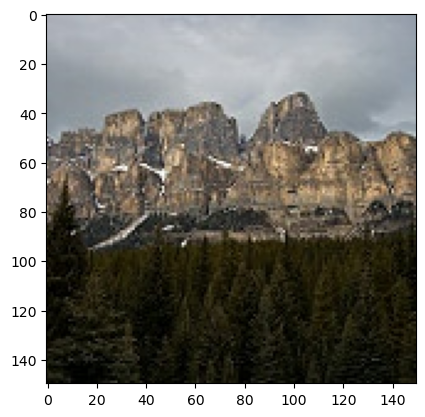

In [5]:
all_image_paths = go_though_database(TRAIN_PATH)

In [6]:
def create_mask(image):
    img_height, img_width = image.shape[:2] #(150, 150, 3)
    mask = 255 * np.ones_like(image) # matrix of ones -> white image
    blackout_start_index = img_width // 3
    
    for i in range(img_height):
        for j in range(img_width):
            if j >= blackout_start_index and j < 2*blackout_start_index:
                mask[i, j] = 0

    return mask

In [7]:
# applys mask to the image 
def edit_image(image_path):
    image = cv2.imread(image_path);
    mask = create_mask(image)

    #print(image.shape)
    #print(mask.shape)
    
    edited_image = cv2.bitwise_and(image, mask)
    
    cv2.imshow('mask', mask)
    cv2.imshow('image', image)
    cv2.imshow('edited_image', edited_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


In [ ]:
edit_image('../dataset/seg_train/seg_train/mountain/9311.jpg')